### Download test files

In [89]:
! wget --quiet https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_49/gencode.v49.annotation.gff3.gz -P ../data/

### Convert to blocked gzip and index (needed for parallel reading)

In [90]:
%%sh
cd ../data
gunzip -c gencode.v49.annotation.gff3.gz  | bgzip -c > gencode.v49.annotation.gff3.bgz
bgzip -r gencode.v49.annotation.gff3.bgz

### Read GFF file with polars-Bio

In [7]:
import polars_bio as pb
import polars as pl

In [8]:
bgz_path = "../data/gencode.v49.annotation.gff3.bgz"

In [93]:
gff_gz = pb.scan_gff("../data/gencode.v49.annotation.gff3.gz")

In [110]:
gff_gz.limit(1).collect()

0rows [00:00, ?rows/s]

chrom,start,end,type,source,score,strand,phase,attributes
str,u32,u32,str,str,f32,str,u32,list[struct[2]]
"""chr1""",11121,24894,"""gene""","""HAVANA""",null,"""+""",null,"[{""ID"",""ENSG00000290825.2""}, {""gene_id"",""ENSG00000290825.2""}, … {""tag"",""overlaps_pseudogene""}]"


In [95]:
gff = pb.scan_gff(bgz_path)

In [96]:
gff.limit(1).collect()

0rows [00:00, ?rows/s]

chrom,start,end,type,source,score,strand,phase,attributes
str,u32,u32,str,str,f32,str,u32,list[struct[2]]
"""chr1""",11121,24894,"""gene""","""HAVANA""",null,"""+""",null,"[{""ID"",""ENSG00000290825.2""}, {""gene_id"",""ENSG00000290825.2""}, … {""tag"",""overlaps_pseudogene""}]"


In [97]:
gff.count().collect()

0rows [00:00, ?rows/s]

chrom,start,end,type,source,score,strand,phase,attributes
u32,u32,u32,u32,u32,u32,u32,u32,u32
7747875,7747875,7747875,7747875,7747875,0,7747875,2720577,7747875


### Parallel reading

In [98]:
gff = pb.scan_gff(bgz_path, parallel=True)

In [99]:
pb.set_option("datafusion.execution.target_partitions", "4")

In [100]:
gff.count().collect()

0rows [00:00, ?rows/s]

chrom,start,end,type,source,score,strand,phase,attributes
u32,u32,u32,u32,u32,u32,u32,u32,u32
7747875,7747875,7747875,7747875,7747875,0,7747875,2720577,7747875


### Projection and predicate and pushdown optimizations

#### Projection pushdown

In [101]:
pb.set_option("datafusion.execution.target_partitions", "1")

In [102]:
pb.scan_gff(bgz_path, parallel=True, projection_pushdown=False).select(["chrom", "start", "end"]).collect()

0rows [00:00, ?rows/s]

chrom,start,end
str,u32,u32
"""chr1""",11121,24894
"""chr1""",11121,14413
"""chr1""",11121,11211
"""chr1""",12010,12227
"""chr1""",12613,12721
…,…,…
"""chrM""",15888,15953
"""chrM""",15888,15953
"""chrM""",15956,16023


In [103]:
pb.scan_gff(bgz_path, parallel=True, projection_pushdown=True).select(["chrom", "start", "end"]).collect()

0rows [00:00, ?rows/s]

chrom,start,end
str,u32,u32
"""chr1""",11121,24894
"""chr1""",11121,14413
"""chr1""",11121,11211
"""chr1""",12010,12227
"""chr1""",12613,12721
…,…,…
"""chrM""",15888,15953
"""chrM""",15888,15953
"""chrM""",15956,16023


#### Increase parallelism

In [109]:
pb.set_option("datafusion.execution.target_partitions", "4")

In [111]:
pb.scan_gff(bgz_path, parallel=True, projection_pushdown=True).select(["chrom", "start", "end"]).collect()

0rows [00:00, ?rows/s]

chrom,start,end
str,u32,u32
"""chr1""",11121,24894
"""chr1""",11121,14413
"""chr1""",11121,11211
"""chr1""",12010,12227
"""chr1""",12613,12721
…,…,…
"""chr10""",6510995,6511194
"""chr10""",6510995,6510998
"""chr10""",6510996,6510998


In [112]:
pb.set_option("datafusion.execution.target_partitions", "8")

In [113]:
pb.scan_gff(bgz_path, parallel=True, projection_pushdown=True).select(["chrom", "start", "end"]).collect()

0rows [00:00, ?rows/s]

chrom,start,end
str,u32,u32
"""chr1""",11121,24894
"""chr1""",11121,14413
"""chr1""",11121,11211
"""chr1""",12010,12227
"""chr1""",12613,12721
…,…,…
"""chr7""",6409837,6409839
"""chr7""",6447843,6447973
"""chr7""",6409126,6409836


#### Predicate pushdown

In [114]:
pb.set_option("datafusion.execution.target_partitions", "1")

In [115]:
lf = pb.scan_gff(bgz_path, parallel=True, predicate_pushdown=False).filter(
    (pl.col("chrom") == "chrY")
    & (pl.col("start") < 500000)
    & (pl.col("end") > 510000)
)

In [116]:
lf.collect()

0rows [00:00, ?rows/s]

chrom,start,end,type,source,score,strand,phase,attributes
str,u32,u32,str,str,f32,str,u32,list[struct[2]]
"""chrY""",386962,511616,"""gene""","""HAVANA""",null,"""+""",null,"[{""ID"",""ENSG00000292349.2""}, {""gene_id"",""ENSG00000292349.2""}, … {""havana_gene"",""OTTHUMG00000189992.1""}]"
"""chrY""",387035,511616,"""transcript""","""HAVANA""",null,"""+""",null,"[{""ID"",""ENST00000972808.1""}, {""Parent"",""ENSG00000292349.2""}, … {""havana_gene"",""OTTHUMG00000189992.1""}]"


In [117]:
lf = pb.scan_gff(bgz_path, parallel=True, predicate_pushdown=True).filter(
    (pl.col("chrom") == "chrY")
    & (pl.col("start") < 500000)
    & (pl.col("end") > 510000)
)

In [118]:
lf.collect()

0rows [00:00, ?rows/s]

chrom,start,end,type,source,score,strand,phase,attributes
str,u32,u32,str,str,f32,str,u32,list[struct[2]]
"""chrY""",386962,511616,"""gene""","""HAVANA""",null,"""+""",null,"[{""ID"",""ENSG00000292349.2""}, {""gene_id"",""ENSG00000292349.2""}, … {""havana_gene"",""OTTHUMG00000189992.1""}]"
"""chrY""",387035,511616,"""transcript""","""HAVANA""",null,"""+""",null,"[{""ID"",""ENST00000972808.1""}, {""Parent"",""ENSG00000292349.2""}, … {""havana_gene"",""OTTHUMG00000189992.1""}]"


#### Increase parallelism

In [119]:
pb.set_option("datafusion.execution.target_partitions", "4")

In [121]:
lf.collect()

0rows [00:00, ?rows/s]

chrom,start,end,type,source,score,strand,phase,attributes
str,u32,u32,str,str,f32,str,u32,list[struct[2]]
"""chrY""",386962,511616,"""gene""","""HAVANA""",null,"""+""",null,"[{""ID"",""ENSG00000292349.2""}, {""gene_id"",""ENSG00000292349.2""}, … {""havana_gene"",""OTTHUMG00000189992.1""}]"
"""chrY""",387035,511616,"""transcript""","""HAVANA""",null,"""+""",null,"[{""ID"",""ENST00000972808.1""}, {""Parent"",""ENSG00000292349.2""}, … {""havana_gene"",""OTTHUMG00000189992.1""}]"


#### Combine projection and predicate pushdown

In [122]:
pb.set_option("datafusion.execution.target_partitions", "1")

In [123]:
(pb.scan_gff(bgz_path, parallel=True, predicate_pushdown=False, projection_pushdown=False)
.select(["chrom", "start", "end", "ID"])
).collect()

0rows [00:00, ?rows/s]

chrom,start,end,ID
str,u32,u32,str
"""chr1""",11121,24894,"""ENSG00000290825.2"""
"""chr1""",11121,14413,"""ENST00000832824.1"""
"""chr1""",11121,11211,"""exon:ENST00000832824.1:1"""
"""chr1""",12010,12227,"""exon:ENST00000832824.1:2"""
"""chr1""",12613,12721,"""exon:ENST00000832824.1:3"""
…,…,…,…
"""chrM""",15888,15953,"""ENST00000387460.2"""
"""chrM""",15888,15953,"""exon:ENST00000387460.2:1"""
"""chrM""",15956,16023,"""ENSG00000210196.2"""


In [124]:
(pb.scan_gff(bgz_path, parallel=True, predicate_pushdown=False, projection_pushdown=False)
.select(["chrom", "start", "end", "ID"])
.filter(
    (pl.col("chrom") == "chrY")
    & (pl.col("start") < 500000)
    & (pl.col("end") > 510000)
)).collect()

0rows [00:00, ?rows/s]

chrom,start,end,ID
str,u32,u32,str
"""chrY""",386962,511616,"""ENSG00000292349.2"""
"""chrY""",387035,511616,"""ENST00000972808.1"""


In [125]:
(pb.scan_gff(bgz_path, parallel=True, predicate_pushdown=True, projection_pushdown=True)
.select(["chrom", "start", "end", "ID"])
.filter(
    (pl.col("chrom") == "chrY")
    & (pl.col("start") < 500000)
    & (pl.col("end") > 510000)
)).collect()

0rows [00:00, ?rows/s]

chrom,start,end,ID
str,u32,u32,str
"""chrY""",386962,511616,"""ENSG00000292349.2"""
"""chrY""",387035,511616,"""ENST00000972808.1"""


In [126]:
pb.set_option("datafusion.execution.target_partitions", "4")

In [127]:
(pb.scan_gff(bgz_path, parallel=True, predicate_pushdown=True, projection_pushdown=True)
.select(["chrom", "start", "end", "ID"])
.filter(
    (pl.col("chrom") == "chrY")
    & (pl.col("start") < 500000)
    & (pl.col("end") > 510000)
)).collect()

0rows [00:00, ?rows/s]

chrom,start,end,ID
str,u32,u32,str
"""chrY""",386962,511616,"""ENSG00000292349.2"""
"""chrY""",387035,511616,"""ENST00000972808.1"""


### Overlaps

In [128]:
pb.set_option("datafusion.execution.target_partitions", "1")

In [11]:
df = pb.scan_gff(bgz_path, projection_pushdown=True,
                 parallel=True).select(["chrom", "start", "end", "ID", "type"])
df2 = pb.scan_gff(bgz_path, projection_pushdown=True,
                  parallel=True).select(["chrom", "start", "end", "source"])
# pb.overlap(df, df2).sink_parquet("/tmp/test.parquet")

In [132]:
pb.overlap(df, df2, suffixes=("_left","_right")).limit(10).collect()

0rows [00:00, ?rows/s]

0rows [00:00, ?rows/s]

0rows [00:00, ?rows/s]

chrom_left,start_left,end_left,ID_left,type_left,chrom_right,start_right,end_right,source_right
str,u32,u32,str,str,str,u32,u32,str
"""chr1""",11121,24894,"""ENSG00000290825.2""","""gene""","""chr1""",17606,17742,"""HAVANA"""
"""chr1""",11121,24894,"""ENSG00000290825.2""","""gene""","""chr1""",17606,17742,"""HAVANA"""
"""chr1""",11121,24894,"""ENSG00000290825.2""","""gene""","""chr1""",17606,17742,"""HAVANA"""
"""chr1""",11121,24894,"""ENSG00000290825.2""","""gene""","""chr1""",17606,17742,"""HAVANA"""
"""chr1""",11121,24894,"""ENSG00000290825.2""","""gene""","""chr1""",16442,16788,"""HAVANA"""
"""chr1""",11121,24894,"""ENSG00000290825.2""","""gene""","""chr1""",16442,16788,"""HAVANA"""
"""chr1""",11121,24894,"""ENSG00000290825.2""","""gene""","""chr1""",16442,16788,"""HAVANA"""
"""chr1""",11121,24894,"""ENSG00000290825.2""","""gene""","""chr1""",16442,18061,"""HAVANA"""
"""chr1""",11121,24894,"""ENSG00000290825.2""","""gene""","""chr1""",14407,14829,"""HAVANA"""


In [133]:
pb.overlap(df, df2).count().collect()

0rows [00:00, ?rows/s]

0rows [00:00, ?rows/s]

0rows [00:00, ?rows/s]

chrom_1,start_1,end_1,ID_1,type_1,chrom_2,start_2,end_2,source_2
u32,u32,u32,u32,u32,u32,u32,u32,u32
995394299,995394299,995394299,995394299,995394299,995394299,995394299,995394299,995394299


In [134]:
pb.overlap(df, df2).filter( (pl.col("type_1") == "gene") & (pl.col("chrom_1") == "chrX") ).collect()

0rows [00:00, ?rows/s]

0rows [00:00, ?rows/s]

0rows [00:00, ?rows/s]

chrom_1,start_1,end_1,ID_1,type_1,chrom_2,start_2,end_2,source_2
str,u32,u32,str,str,str,u32,u32,str
"""chrX""",253743,255091,"""ENSG00000228572.7""","""gene""","""chrX""",253743,253846,"""HAVANA"""
"""chrX""",253743,255091,"""ENSG00000228572.7""","""gene""","""chrX""",253743,255091,"""HAVANA"""
"""chrX""",253743,255091,"""ENSG00000228572.7""","""gene""","""chrX""",253743,255091,"""HAVANA"""
"""chrX""",253743,255091,"""ENSG00000228572.7""","""gene""","""chrX""",254937,255091,"""HAVANA"""
"""chrX""",267677,276210,"""ENSG00000303837.1""","""gene""","""chrX""",267677,267868,"""HAVANA"""
…,…,…,…,…,…,…,…,…
"""chrX""",156025664,156027877,"""ENSG00000227159.8""","""gene""","""chrX""",156027830,156028047,"""HAVANA"""
"""chrX""",156025664,156027877,"""ENSG00000227159.8""","""gene""","""chrX""",156027830,156028047,"""HAVANA"""
"""chrX""",156025664,156027877,"""ENSG00000227159.8""","""gene""","""chrX""",156027830,156028047,"""HAVANA"""


In [9]:
pb.set_option("datafusion.execution.target_partitions", "4")

In [14]:
pb.overlap(df, df2).count().collect()

0rows [00:00, ?rows/s]

0rows [00:00, ?rows/s]

0rows [00:00, ?rows/s]

chrom_1,start_1,end_1,ID_1,type_1,chrom_2,start_2,end_2,source_2
u32,u32,u32,u32,u32,u32,u32,u32,u32
995394299,995394299,995394299,995394299,995394299,995394299,995394299,995394299,995394299


In [15]:
pb.set_option("datafusion.execution.target_partitions", "8")

In [16]:
pb.overlap(df, df2).count().collect()

0rows [00:00, ?rows/s]

0rows [00:00, ?rows/s]

0rows [00:00, ?rows/s]

chrom_1,start_1,end_1,ID_1,type_1,chrom_2,start_2,end_2,source_2
u32,u32,u32,u32,u32,u32,u32,u32,u32
995394299,995394299,995394299,995394299,995394299,995394299,995394299,995394299,995394299


In [17]:
pb.overlap(df, df2).sink_parquet("/tmp/test.parquet")

0rows [00:00, ?rows/s]

0rows [00:00, ?rows/s]

0rows [00:00, ?rows/s]

In [18]:
par_lf = pl.scan_parquet("/tmp/test.parquet")

In [19]:
par_lf.limit(1).collect()

chrom_1,start_1,end_1,ID_1,type_1,chrom_2,start_2,end_2,source_2
str,u32,u32,str,str,str,u32,u32,str
"""chr1""",24502340,24503117,"""UTR5:ENST00000938486.1""","""five_prime_UTR""","""chr1""",24502340,24503117,"""HAVANA"""


In [20]:
par_lf.count().collect()

chrom_1,start_1,end_1,ID_1,type_1,chrom_2,start_2,end_2,source_2
u32,u32,u32,u32,u32,u32,u32,u32,u32
995394299,995394299,995394299,995394299,995394299,995394299,995394299,995394299,995394299


### Memory usage considerations

In [21]:
%%sh
rm -f overlap_coordinates_only.dat overlap_coordinates_only.png
mprof run --output overlap_coordinates_only.dat src/overlap_coordinates_only.py 2> /dev/null
mprof peak overlap_coordinates_only.dat
mprof plot overlap_coordinates_only.dat --output overlap_coordinates_only.png

mprof: Sampling memory every 0.1s
running new process
running as a Python program...
overlap_coordinates_only.dat	1525.797 MiB


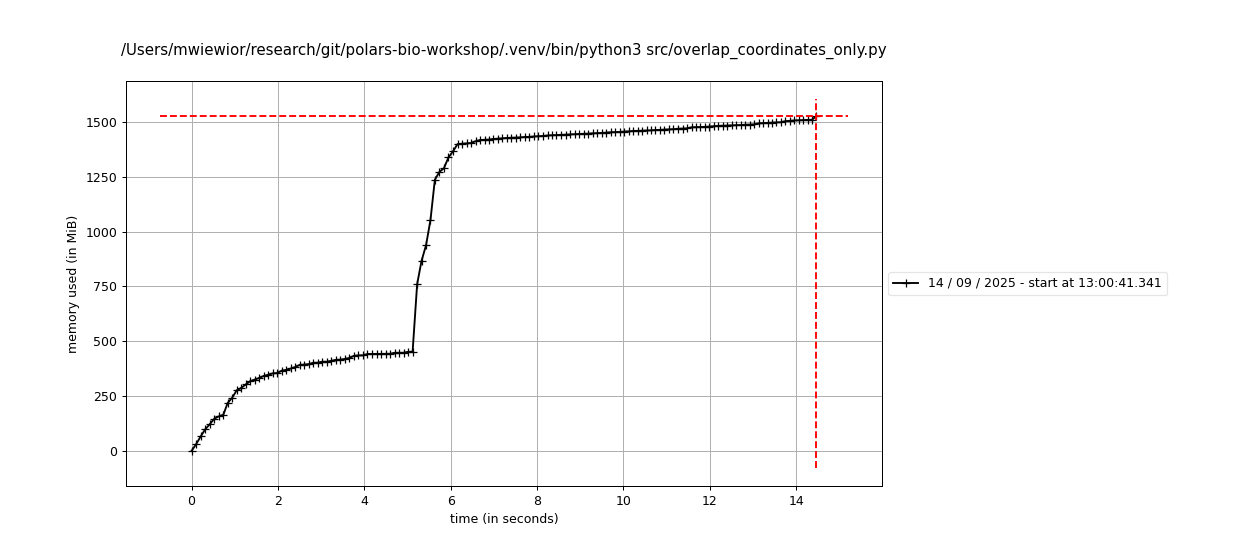

In [22]:
from IPython.display import Image
Image("overlap_coordinates_only.png")

In [23]:
%%sh
rm -f overlap.dat overlap.png
mprof run --output overlap.dat src/overlap.py 2> /dev/null
mprof peak overlap.dat
mprof plot overlap.dat --output overlap.png

mprof: Sampling memory every 0.1s
running new process
running as a Python program...
overlap.dat	25266.375 MiB


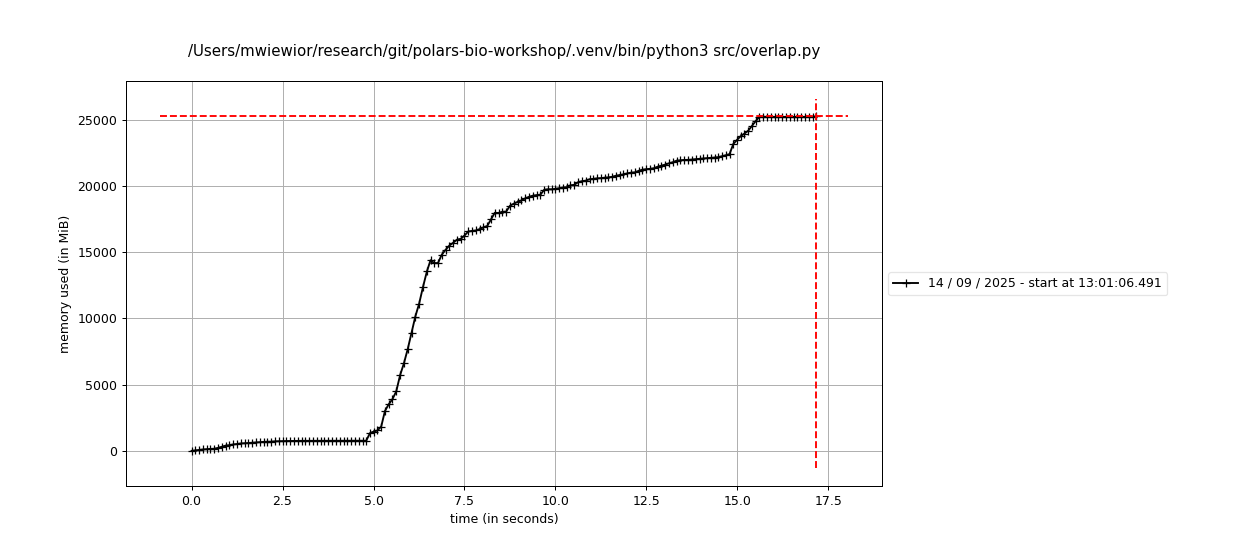

In [24]:
from IPython.display import Image
Image("overlap.png")

In [25]:
%%sh
rm -f overlap_low_memory.dat overlap_low_memory.png
mprof run --output overlap_low_memory.dat src/overlap_low_memory.py 2> /dev/null
mprof peak overlap_low_memory.dat
mprof plot overlap_low_memory.dat --output overlap_low_memory.png

mprof: Sampling memory every 0.1s
running new process
running as a Python program...
overlap_low_memory.dat	3095.984 MiB


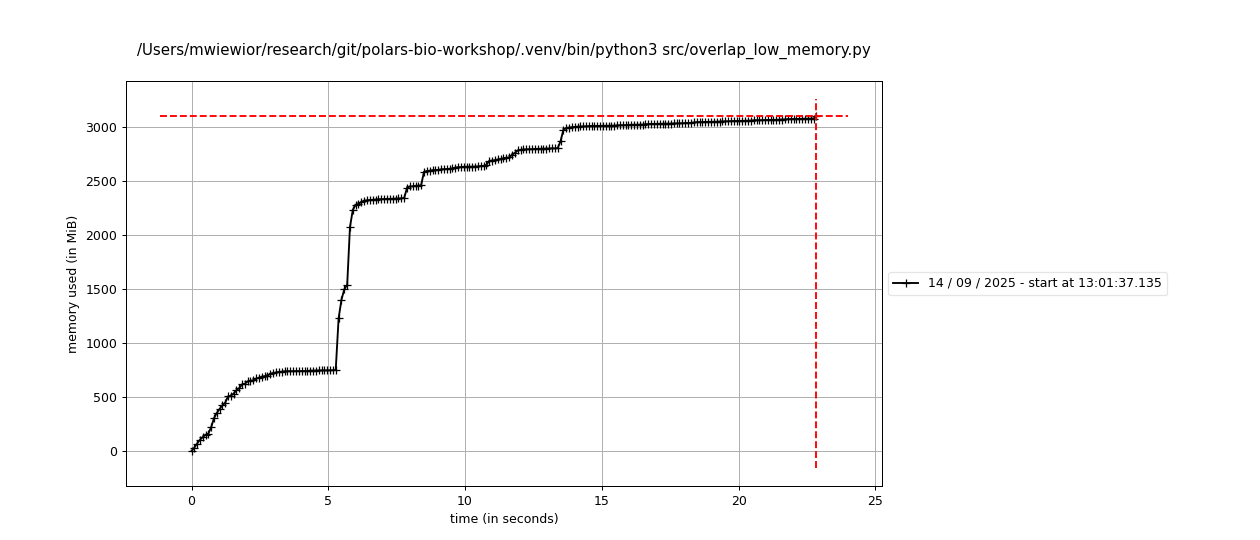

In [26]:
from IPython.display import Image
Image("overlap_low_memory.png")